In [1]:
import os
import torch
from layers import SpatialTransformer
import numpy as np
import nibabel as nib


from skimage.transform import resize
from scipy.ndimage.interpolation import affine_transform
from helpers import normalizeImage, random_transform, compute_negative_jacobian
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [12]:
folder = "/mnt/blackhole-data2/RadOnc_Brain"

CT_min = -100.0
CT_max = 100.0
CBCT_min = -100.0
CBCT_max = 100.0
T1_min = -100.0 ##?
T1_max = 2300.0 ## ?
config = dict()

config['image_size'] = [128, 160, 128]
config['num_samples'] = 1
# config['augment_translation'] = 5
# config['augment_rotation'] = 5
config['augment_n_points'] = [1, 5]  # number of points in deformation simulation
config['augment_decay_power_range'] =  [5e-3, 3e-2] # [1e-2,1e-1] [3e-2,5e-2] [5e-2,9e-2] [9e-3,3e-2] [6e-3,9e-3] # decay power range in deformation simulation
config['augment_decay_power_range_unit'] =  [1, 2]
config['augment_deformation_range'] = [2, 5]  # deformation magnitude range in deformation simulation
config['augment_deformation_range_unit'] = [1, 2]

In [3]:
indices = np.arange(6, 8)
n_moving = []
n_fixed = []
n_cbct = []
n_mask_ventricle = []
n_mask_brain = []
for i in indices:
    n_fixed.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CT-crop-resampled.nii")).get_fdata())
    n_cbct.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CBCT_OArm-crop-resampled.nii")).get_fdata())
    n_moving.append(nib.load(os.path.join(folder, f"NormalAnatomy", f"atlas_brain_{i:02}_T1-crop-resampled.nii")).get_fdata())
    n_mask_ventricle.append(np.squeeze(nib.load(os.path.join(folder, f"MALPEM-MR-Brain-Segmentations",
                                                             f"atlas_brain_{i:02}_T1-crop-resampled_MALPEM.nii.gz")).get_fdata()))
    n_mask_brain.append(nib.load(os.path.join(folder, f"NormalAnatomy_Mask", f"atlas_brain_{i:02}_brain_mask.nii.gz")).get_fdata())

In [13]:
from layers import VecInt
from scipy.ndimage import distance_transform_edt as bwdist

class SourceWarpPoint:
    def __init__(self, point, decay_power=1, deformation_magnitude=6):

        # Default values
        self.decay_power = decay_power
        self.deformation_magnitude = deformation_magnitude
        self.point = point

    def print(self):
        print('point: ', self.point, ' decay power: ', self.decay_power,
              ' deformation magnitude: ', self.deformation_magnitude)


class SourceGen:
    """
    Randomly generate source points with:
    n_points: number of source points to drive deformation
    random decay power: min and max value
    deformation magnitude: min and max value
    Source points are randomly located with a given mask (e.g ventricle)
    """
    def __init__(self, n_points, image_shape, decay_power_range=[0.5, 2], deformation_magnitude_range=[1, 5]):
        self.image_shape = image_shape
        self.decay_power_range = decay_power_range
        self.deformation_magnitude_range = deformation_magnitude_range
        self.n_points = n_points

    def run(self, ventricle_mask=None):
        points = []
        sources = []

        if ventricle_mask is None:
            x, y, z = np.meshgrid(np.linspace(0, self.image_shape[0]-1, self.image_shape[0]),
                                  np.linspace(0, self.image_shape[1]-1, self.image_shape[1]),
                                  np.linspace(0, self.image_shape[2]-1, self.image_shape[2]))
        else:
            islice = np.argmax(np.sum(ventricle_mask > 0, axis=(0, 1)))  # find the slice with the largest masked volume
            mask_center = np.zeros(ventricle_mask.shape)
            mask_center[:, :, islice-5:islice+4] = ventricle_mask[:, :, islice - 5:islice + 4]  # only place sources around ±5 slices from islice
            x, y, z = np.where(mask_center > 0)
            loc = np.where(z == islice)
            nloc = [loc[0][0],loc[0][-1]]

        index = np.random.randint(len(x), size=self.n_points)
        for i in range(self.n_points):
            points.append([x[nloc[0]], y[nloc[0]], islice])
            # points.append([x[index[i]], y[index[i]], z[index[i]]])
            np.random.seed(123)
            alpha = np.random.uniform(low=self.deformation_magnitude_range[0], high=self.deformation_magnitude_range[1])
            beta_exp = np.random.uniform(low=np.log(self.decay_power_range[0]),
                                         high=np.log(np.minimum(self.decay_power_range[1], np.log2(alpha/(alpha-1)))))
            beta = np.exp(beta_exp)

            sources.append(SourceWarpPoint(point=points[i], decay_power=beta,
                                           deformation_magnitude=alpha*np.random.choice([-1, 1])))
        return sources


class Simulator:
    """
    Simulate a random deformation field based on source model D=a/r^b from multiple source points.

    Returns
    -------
    D : the overall deformation field

    """

    def __init__(self, image_size=[192, 240, 192], int_steps=2,unit = False):

        self._image_size = image_size
        # self.transformer = SpatialTransformer(image_size, mode=interp_method)
        self.vectint = VecInt(image_size, int_steps)  # square and scaling layer for exponentiation
        self.unit = unit

    def simulate(self, sources, brain_mask=None, thresh=30):
        """
        sources: sources to drive deformation, generated from SourceGen
        brain_mask: optional mask of the brain region, deformation outside is set to 0
        thresh: a threshold of the distance to the brain boundary (value above thresh is not affected)
        """
        [X, Y, Z] = np.mgrid[0:self._image_size[0], 0:self._image_size[1], 0:self._image_size[2]]
        D = np.zeros((3, self._image_size[0], self._image_size[1], self._image_size[2]))
        
        for source in sources:
            decay_power = source.decay_power
            deformation_mag = source.deformation_magnitude
        
            if self.unit:
                R2 = np.square((X-source.point[0])*1.5/0.7) + np.square((Y-source.point[1])*1.5/0.7) + np.square((Z-source.point[2])*1.5)
            else:
                R2 = np.square((X-source.point[0])) + np.square((Y-source.point[1])) + np.square((Z-source.point[2]))
            F = deformation_mag/(np.power(R2, decay_power/2)+1e-6) # deformation magnitude (+retraction,-dilation)
            F[source.point[0], source.point[1], source.point[2]] = deformation_mag

            # DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F*(0.7/1.5)**(1-decay_power)
            # DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F*(0.7/1.5)**(1-decay_power)
            # DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F*(1/1.5)**(1-decay_power)
            
            # DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F*(0.7/1.5)
            # DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F*(0.7/1.5)
            # DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F*(1/1.5)

            DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F
            DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F
            DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F
            
            # DX[source.point[0],:,:] = deformation_mag
            # DY[:,source.point[1],:] = deformation_mag
            # DZ[:,:,source.point[2]] = deformation_mag
            

            D = D + np.stack((DX, DY, DZ), axis=0)
            

        if brain_mask is not None:  # set deformation outside the brain to 0 with smooth transitions
            brain_dist = bwdist(brain_mask) / 30
            brain_dist[brain_dist > 1] = 1
            D = np.multiply(D, np.repeat(brain_dist[np.newaxis, :, :], 3, axis=0))

        D = self.vectint(torch.from_numpy(D).unsqueeze(0).float())
        
        return D
    



In [14]:
simulator = Simulator(image_size=config['image_size'])
original_shape = config['image_size']
transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
transformer_nearest = SpatialTransformer(original_shape, mode='nearest')

simulator_runze = Simulator(image_size=n_moving[0].shape)
original_shape_runze = n_moving[0].shape
transformer_linear_runze = SpatialTransformer(original_shape_runze, mode='bilinear')
transformer_nearest_runze = SpatialTransformer(original_shape_runze, mode='nearest')

In [32]:
n_moving[0].shape

(271, 340, 183)

In [15]:
from tqdm import tqdm
for i in tqdm(range(config['num_samples'])):
    index = 0
    ct_runze = n_fixed[index]
    mr_runze = n_moving[index]
    cbct_runze = n_cbct[index]
    mask_ventricle_runze = n_mask_ventricle[index]
    mask_brain_runze = n_mask_brain[index]
    
    ct = resize(ct_runze,config['image_size'], order=3)
    mr = resize(mr_runze,config['image_size'], order=3)
    cbct = resize(cbct_runze,config['image_size'], order=3)
    mask_ventricle = resize(n_mask_ventricle[index],config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    mask_brain = resize(n_mask_brain[index],config['image_size'], order=0, anti_aliasing=False).astype(np.int8)

    # Simulate deformations
    # n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    n_points = 1
    source_gen= SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range'], deformation_magnitude_range=config['augment_deformation_range'])
    source_gen_unit= SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range_unit'], deformation_magnitude_range=config['augment_deformation_range_unit'])
    source_gen_runze = SourceGen(n_points, original_shape_runze, decay_power_range=config['augment_decay_power_range'], deformation_magnitude_range=config['augment_deformation_range'])
    
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sources_unit = source_gen_unit.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sources_runze = source_gen_runze.run(ventricle_mask=(mask_ventricle_runze == 23) + (mask_ventricle_runze == 24))
    
    sim = Simulator(original_shape)
    sim_unit = Simulator(original_shape)
    sim_runze = Simulator(original_shape_runze)
    
    flow = sim.simulate(sources, mask_brain)
    # flow_unit = flow
    # flow_unit[0,0,:,:,:] *= 0.7/1.5
    # flow_unit[0,1,:,:,:] *= 1.5
    flow_unit = sim_unit.simulate(sources_unit, mask_brain)
    flow_runze = sim_runze.simulate(sources_runze, mask_brain_runze)

    ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    
    ct_runze = torch.from_numpy(ct_runze).unsqueeze(0).unsqueeze(0).float()
    mr_runze = torch.from_numpy(mr_runze).unsqueeze(0).unsqueeze(0).float()
    cbct_runze = torch.from_numpy(cbct_runze).unsqueeze(0).unsqueeze(0).float()
    mask_runze = torch.from_numpy(mask_ventricle_runze).unsqueeze(0).unsqueeze(0).float()
    
    ct_deform = transformer_linear(ct, flow)
    mr_deform = transformer_linear(mr, flow)
    cbct_deform = transformer_linear(cbct, flow)
    mask_deform = transformer_nearest(mask, flow)
    
    ct_deform_unit = transformer_linear(ct, flow_unit)
    mr_deform_unit = transformer_linear(mr, flow_unit)
    cbct_deform_unit = transformer_linear(cbct, flow_unit)
    mask_deform_unit = transformer_nearest(mask, flow_unit)
    
    ct_deform_runze = transformer_linear_runze(ct_runze, flow_runze)
    mr_deform_runze = transformer_linear_runze(mr_runze, flow_runze)
    cbct_deform_runze = transformer_linear_runze(cbct_runze, flow_runze)
    mask_deform_runze =  transformer_nearest_runze(mask_runze, flow_runze)

    mr = normalizeImage(mr, T1_max, T1_min)
    mr_deform = normalizeImage(mr_deform, T1_max, T1_min)
    ct = normalizeImage(ct, CT_max, CT_min)
    
    ct_deform = normalizeImage(ct_deform, CT_max, CT_min)
    cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
    cbct_deform = normalizeImage(cbct_deform, CBCT_max, CBCT_min)

    mr_deform_unit = normalizeImage(mr_deform_unit, T1_max, T1_min)
    ct_deform_unit = normalizeImage(ct_deform_unit, CT_max, CT_min)
    cbct_deform_unit = normalizeImage(cbct_deform_unit, CBCT_max, CBCT_min)
    
    mr_deform_runze = resize(mr_deform_runze.squeeze().squeeze(), config['image_size'], order=3)
    mr_deform_runze = normalizeImage(mr_deform_runze, T1_max, T1_min)
    
    mask_deform_runze =  resize(mask_deform_runze.squeeze().squeeze(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    # ct = resize(ct.squeeze().numpy(), config['image_size'], order=3)
    # ct = normalizeImage(ct, CT_max, CT_min)
    # ct_deform = resize(ct_deform.squeeze().numpy(), config['image_size'], order=3)
    # ct_deform = normalizeImage(ct_deform, CT_max, CT_min)
    # cbct = resize(cbct.squeeze().numpy(), config['image_size'], order=3)
    # cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
    # cbct_deform = resize(cbct_deform.squeeze().numpy(), config['image_size'], order=3)
    # cbct_deform = normalizeImage(cbct_deform, CBCT_max, CBCT_min)

    # mask = resize(mask.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    # mask_deform = resize(mask_deform.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    

    # ct_deform_runze = normalizeImage(ct_deform_runze, CT_max, CT_min)
    # cbct_deform_runze = normalizeImage(cbct_deform_runze, CBCT_max, CBCT_min)
    

 


100%|██████████| 1/1 [00:23<00:00, 23.22s/it]


In [16]:
for source in sources:
    print(source.point,source.decay_power,source.deformation_magnitude)
for source in sources_unit:
    print(source.point,source.decay_power,source.deformation_magnitude)
for source in sources_runze:
    print(source.point,source.decay_power,source.deformation_magnitude)

[48, 106, 70] 0.008348908196054546 -4.089407556793585
[48, 106, 70] 1.0742461303925472 -1.6964691855978615
[102, 225, 100] 0.008348908196054546 -4.089407556793585


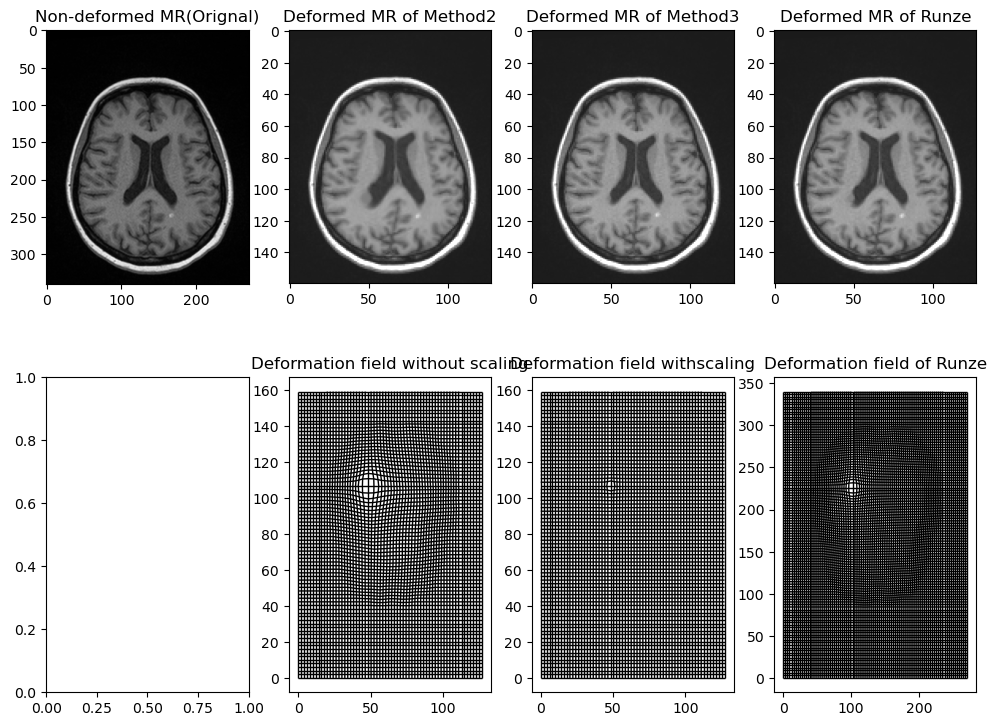

In [17]:
from matplotlib.collections import LineCollection
def plot_flow(flow, z, spacing=4, ax=None):
    def plot_grid(x,y, ax=ax, **kwargs):
        ax = ax or plt.gca()
        segs1 = np.stack((x,y), axis=2)
        segs2 = segs1.transpose(1,0,2)
        ax.add_collection(LineCollection(segs1, **kwargs))
        ax.add_collection(LineCollection(segs2, **kwargs))
        ax.autoscale()

    grid_x,grid_y = np.meshgrid(np.linspace(0, flow.shape[1], flow.shape[1]), np.linspace(0, flow.shape[0], flow.shape[0]))
#     plot_grid(grid_x[::spacing, ::spacing],grid_y[::spacing, ::spacing], ax=ax,  color="lightgrey")

    distx = grid_x[::spacing, ::spacing] - flow[::spacing, ::spacing, z, 1]
    disty = grid_y[::spacing, ::spacing] - flow[::spacing, ::spacing, z, 0]
    # distx, disty = f(grid_x,grid_y)
    plot_grid(disty, distx, ax=ax, color="black", linewidths=1)
    
islice = sources[0].point[2]
islice_runze = sources_runze[0].point[2]
plt.style.use('default')
fig, ax = plt.subplots(2,4,figsize=(12,9))

ax[0, 0].imshow(normalizeImage(n_moving[index], T1_max, T1_min)[:,:,islice_runze].T, cmap='gray')
ax[0, 0].set_title('Non-deformed MR(Orignal)')
ax[0, 1].imshow(mr_deform[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 1].set_title('Deformed MR of Method2')
ax[0, 2].imshow(mr_deform_unit[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 2].set_title('Deformed MR of Method3')
ax[0, 3].imshow(mr_deform_runze[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 3].set_title('Deformed MR of Runze')
plot_flow(flow[0].numpy().transpose(1,2,3,0), spacing=2, z=islice, ax=ax[1, 1])
ax[1, 1].set_title('Deformation field without scaling')
plot_flow(flow_unit[0].numpy().transpose(1,2,3,0), spacing=2, z=islice, ax=ax[1, 2])
ax[1, 2].set_title('Deformation field withscaling')
plot_flow(flow_runze[0].numpy().transpose(1,2,3,0), spacing=3, z=islice_runze, ax=ax[1, 3])
ax[1, 3].set_title('Deformation field of Runze')

plt.show()

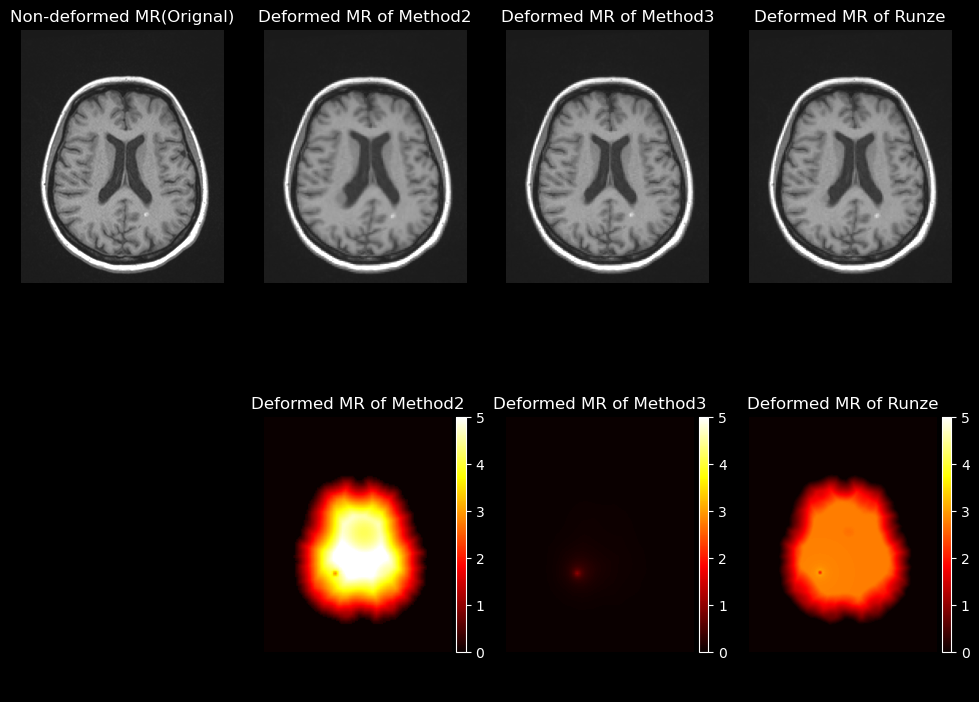

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
dist = ((1.5*flow[0,0,:,:,:])**2+(1.5*flow[0,1,:,:,:])**2+(1.5*flow[0,2,:,:,:])**2)**0.5
dist_unit = ((1.5*flow_unit[0,0,:,:,:])**2+(1.5*flow_unit[0,1,:,:,:])**2+(1.5*flow_unit[0,2,:,:,:])**2)**0.5
dist_runze = ((0.7*flow_runze[0,0,:,:,:])**2+(0.7*flow_runze[0,1,:,:,:])**2+(flow_runze[0,2,:,:,:])**2)**0.5

islice = sources[0].point[2]
islice_runze = sources_runze[0].point[2]
plt.style.use('dark_background')
fig, ax = plt.subplots(2,4,figsize=(12,9))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0, 0].imshow(normalizeImage(n_moving[index], T1_max, T1_min)[:,:,islice_runze].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 0].set_title('Non-deformed MR(Orignal)')
ax[0, 1].imshow(mr_deform[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 1].set_title('Deformed MR of Method2')
ax[0, 2].imshow(mr_deform_unit[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 2].set_title('Deformed MR of Method3')
ax[0, 3].imshow(mr_deform_runze[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 3].set_title('Deformed MR of Runze')


imx1 = ax[1, 1].imshow(dist[:,:,islice+2].T, cmap='hot', vmin=0,vmax = 5)
c
fig.colorbar(imx1, cax=cax, orientation='vertical')
ax[1, 1].set_title('Deformed MR of Method2')


imx2 = ax[1, 2].imshow(dist_unit[:,:,islice+2].T,  cmap='hot', vmin=0,vmax = 5)
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imx2, cax=cax, orientation='vertical')
ax[1, 2].set_title('Deformed MR of Method3')

imx3 = ax[1, 3].imshow(dist_runze[:,:,islice_runze+2].T, cmap='hot', vmin=0,vmax = 5)
divider = make_axes_locatable(ax[1,3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imx3, cax=cax, orientation='vertical')
ax[1, 3].set_title('Deformed MR of Runze')


plt.show()

Text(0.5, 1.0, 'Difference of deformation with scaling')

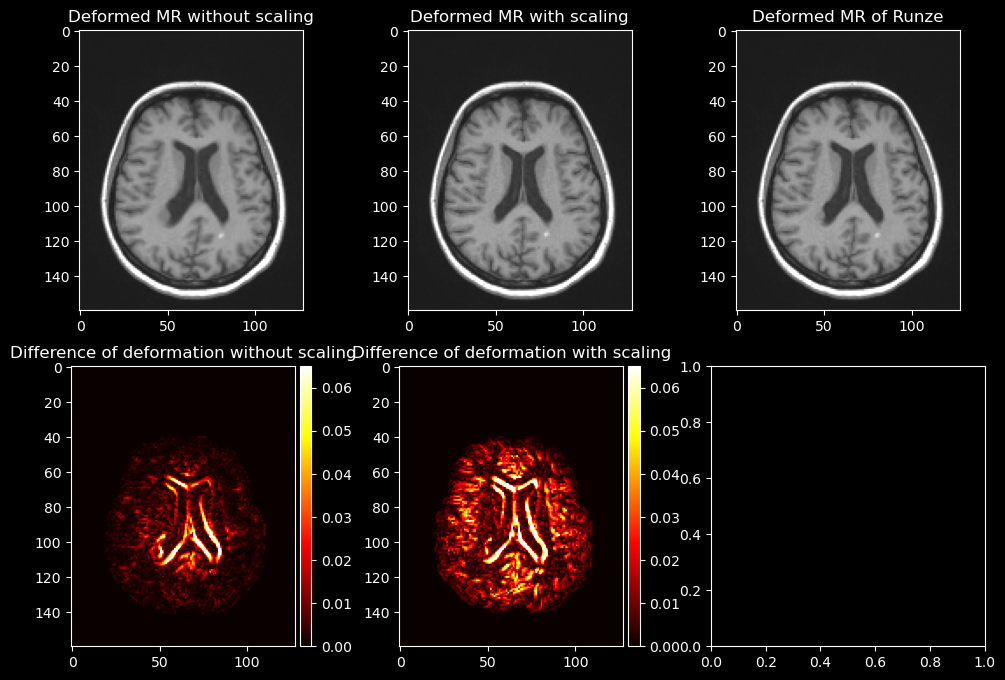

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')
fig, ax = plt.subplots(2,3,figsize=(12,8))
ax[0, 0].imshow(mr_deform[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 0].set_title('Deformed MR without scaling')
ax[0, 1].imshow(mr_deform_unit[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 1].set_title('Deformed MR with scaling')
ax[0, 2].imshow(mr_deform_runze[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 2].set_title('Deformed MR of Runze')

imx2 = ax[1,0].imshow(abs(mr_deform[0,0,:,:,islice].T-mr_deform_runze[:,:,islice].T), cmap='hot', vmin=0,vmax = 0.065)
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imx2, cax=cax, orientation='vertical')
ax[1,0].set_title('Difference of deformation without scaling')

imx2 = ax[1,1].imshow(abs(mr_deform_unit[0,0,:,:,islice].T-mr_deform_runze[:,:,islice].T), cmap='hot', vmin=0,vmax = 0.065)
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imx2, cax=cax, orientation='vertical')
ax[1,1].set_title('Difference of deformation with scaling')

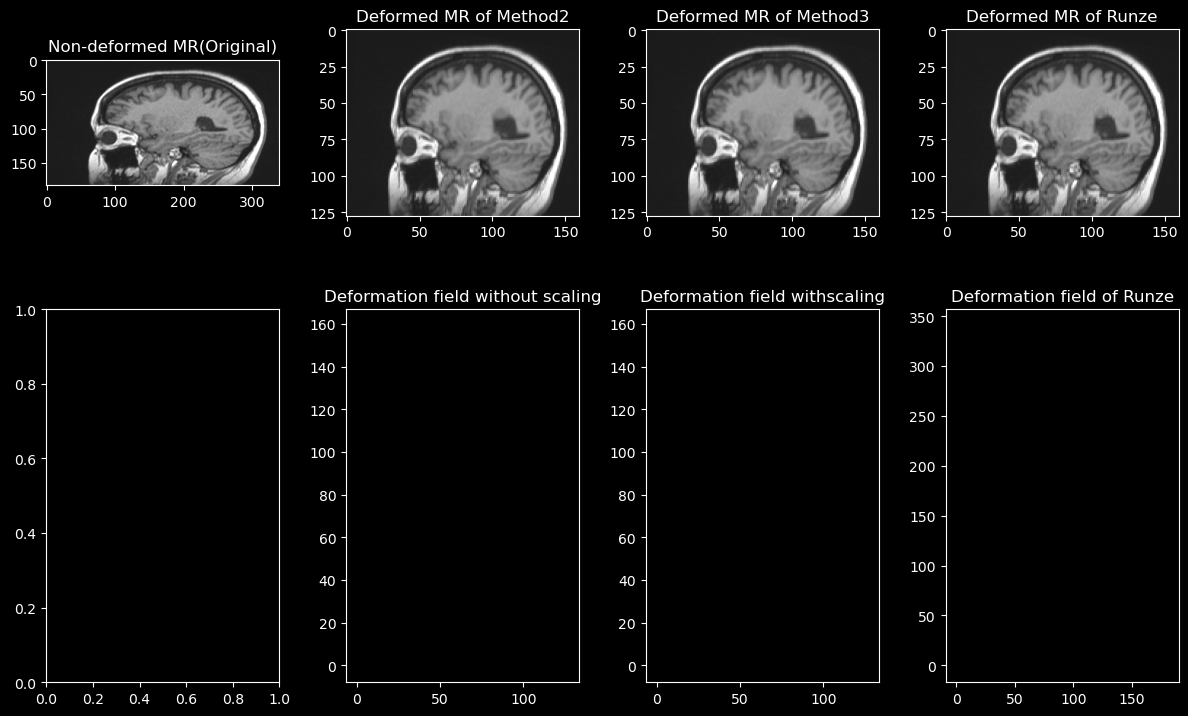

In [54]:
def plot_flow_x(flow, x, spacing=4, ax=None):
    def plot_grid(y, z, ax=ax, **kwargs):
        ax = ax or plt.gca()
        segs1 = np.stack((y, z), axis=2)
        segs2 = segs1.transpose(1, 0, 2)
        # segs2 = segs1.transpose(1, 0, 2)
        ax.add_collection(LineCollection(segs1, **kwargs))
        ax.add_collection(LineCollection(segs2, **kwargs))
        ax.autoscale()

    grid_x, grid_y = np.meshgrid(
        np.linspace(0, flow.shape[2], flow.shape[2]),
        np.linspace(0, flow.shape[1], flow.shape[1])
    )

    # Extract deformation data based on the desired x coordinate
    distx = grid_x[::spacing, ::spacing] - flow[x, ::spacing, ::spacing, 2]
    disty = grid_y[::spacing, ::spacing] - flow[x, ::spacing, ::spacing, 1]

    plot_grid(distx, disty, ax=ax, color="black", linewidths=1)

islice = sources[0].point[0]
islice_runze = sources_runze[0].point[0]
plt.style.use('dark_background')
fig, ax = plt.subplots(2,4,figsize=(12,8))
mr[0,0,sources[0].point[0],sources[0].point[1],sources[0].point[2]] = 1
# np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0, 0].imshow(np.flipud(normalizeImage(n_moving[index], T1_max, T1_min)[islice_runze,:,:].T), cmap='gray', vmin=0, vmax=0.4)
ax[0, 0].set_title('Non-deformed MR(Original)')
ax[0, 1].imshow(torch.flipud(mr_deform[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
ax[0, 1].set_title('Deformed MR of Method2')
ax[0, 2].imshow(torch.flipud(mr_deform_unit[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
ax[0, 2].set_title('Deformed MR of Method3')
ax[0, 3].imshow(np.flipud(mr_deform_runze[islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
ax[0, 3].set_title('Deformed MR of Runze')
plot_flow_x(flow[0].numpy().transpose(1,2,3,0), spacing=2, x=islice, ax=ax[1, 1])
ax[1, 1].set_title('Deformation field without scaling')
plot_flow_x(flow_unit[0].numpy().transpose(1,2,3,0), spacing=2, x=islice, ax=ax[1, 2])
ax[1, 2].set_title('Deformation field withscaling')
plot_flow_x(flow_runze[0].numpy().transpose(1,2,3,0), spacing=3, x=islice_runze, ax=ax[1, 3])
ax[1, 3].set_title('Deformation field of Runze')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Difference of deformation with scaling')

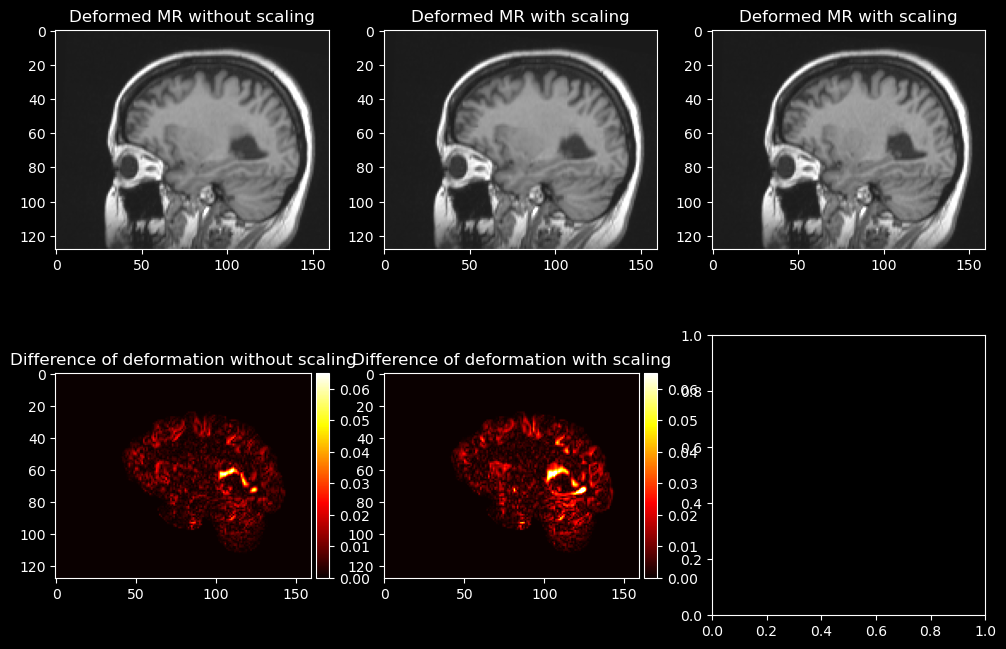

In [163]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

fig, ax = plt.subplots(2,3,figsize=(12,8))
# np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0, 0].imshow(torch.flipud(mr_deform[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
ax[0, 0].set_title('Deformed MR without scaling')
ax[0, 1].imshow(torch.flipud(mr_deform_unit[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
ax[0, 1].set_title('Deformed MR with scaling')
ax[0, 2].imshow(np.flipud(mr_deform_runze[islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
ax[0, 2].set_title('Deformed MR with scaling')

imx2 = ax[1,0].imshow(np.flipud(abs(mr_deform[0,0,islice,:,:].T-mr_deform_runze[islice,:,:].T)), cmap='hot', vmin=0,vmax = 0.065)
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imx2, cax=cax, orientation='vertical')
ax[1,0].set_title('Difference of deformation without scaling')

imx2 = ax[1,1].imshow(abs(np.flipud(mr_deform_unit[0,0,islice,:,:].T-mr_deform_runze[islice,:,:].T)), cmap='hot', vmin=0,vmax = 0.065)
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imx2, cax=cax, orientation='vertical')
ax[1,1].set_title('Difference of deformation with scaling')


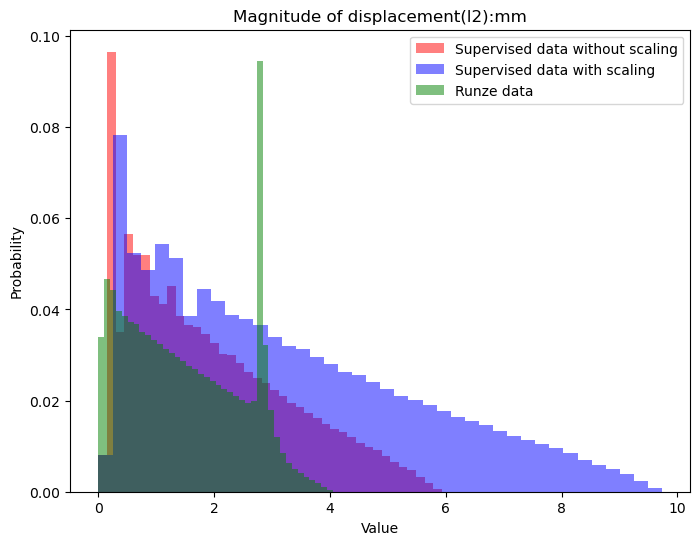

In [73]:

data = flow*1.5
data_unit = flow_unit*1.5
data_runze = flow_runze.clone()
data_runze[0,0,:,:,:]*= 0.7
data_runze[0,1,:,:,:]*= 0.7

plt.style.use('default')
magnitude = (data[0,0,:,:,:,]**2+data[0,1,:,:,:]**2+data[0,2,:,:,:]**2)**0.5
magnitude_unit = (data_unit[0,0,:,:,:,]**2+data_unit[0,1,:,:,:]**2+data_unit[0,2,:,:,:]**2)**0.5
magnitude_runze = (data_runze[0,0,:,:,:,]**2+data_runze[0,1,:,:,:]**2+data_runze[0,2,:,:,:]**2)**0.5

mag_list = magnitude.flatten().tolist()
mag_list = [x for x in mag_list if x!=0.0]

mag_unit_list = magnitude_unit.flatten().tolist()
mag_unit_list = [x for x in mag_unit_list if x!=0.0]

mag_runze_list = magnitude_runze.flatten().tolist()
mag_runze_list = [x for x in mag_runze_list if x!=0.0]

weights = np.ones_like(mag_list)/float(len(mag_list))
weights_unit = np.ones_like(mag_unit_list)/float(len(mag_unit_list))
weights_runze = np.ones_like(mag_runze_list)/float(len(mag_runze_list))

plt.figure(figsize=(8, 6))

# 绘制两组数据的直方图
plt.hist(mag_list, bins=40, alpha=0.5, color='red', label = 'Supervised data without scaling',weights=weights)
plt.hist(mag_unit_list, bins=40, alpha=0.5, color='blue', label = 'Supervised data with scaling',weights=weights_unit)
plt.hist(mag_runze_list, bins=40, alpha=0.5, color='green', label = 'Runze data',weights=weights_runze)

# 添加标签和图例
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Magnitude of displacement(l2):mm')
plt.legend()

# 显示图形
plt.show()

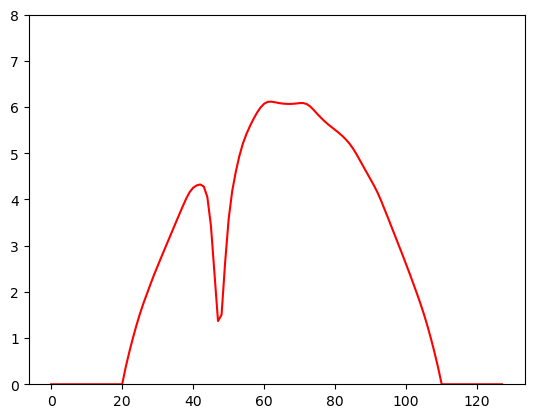

In [199]:
prof2 = magnitude[:,sources[0].point[1],sources[0].point[2]]
plt.ylim([0,8])
plt.plot(prof2,color = 'red')


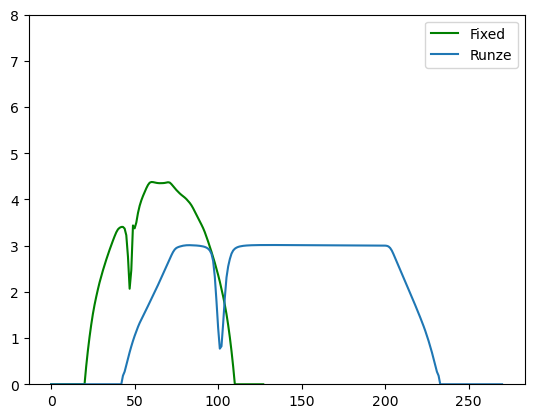

In [168]:
prof2_unit = magnitude_unit[:,sources[0].point[1],sources[0].point[2]]
plt.ylim([0,8])
plt.plot(prof2_unit,color = 'green',label = 'Fixed')
plt.plot(prof2_runze,label = 'Runze')
plt.legend()

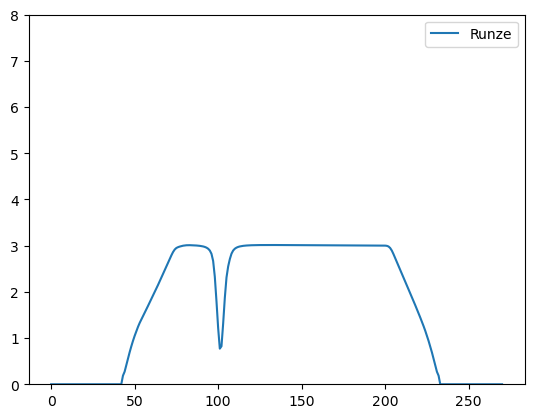

In [167]:
prof2_runze = magnitude_runze[:,sources_runze[0].point[1],sources_runze[0].point[2]]
plt.ylim([0,8])
plt.plot(prof2_runze,label = 'Runze')
plt.legend()

In [93]:
import losses
dice = torch.from_numpy(mask_deform_runze)*mask_deform
dice_unit = append(-losses.Dice().loss(torch.from_numpy(mask_deform_runze),mask_deform_unit).item())

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

In [37]:
[X, Y, Z] = np.mgrid[0:128, 0:160, 0:150]
Z[:,:,9]

array([[9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       ...,
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9]])

In [21]:
for i in range(config['num_samples']):
    # index = np.random.randint(len(n_moving))
    #index = np.mod(i,5)
    index = 0
    ct = n_fixed[index]
    mr = n_moving[index]
    cbct = n_cbct[index]
    mask_ventricle = n_mask_ventricle[index]
    mask_brain = n_mask_brain[index]

    # Simulate deformations
    n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    source_gen = SourceGen(n_points, original_shape_runze, decay_power_range=config['augment_decay_power_range'],
                           deformation_magnitude_range=config['augment_deformation_range'])
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sim = Simulator(original_shape_runze)
    flow = sim.simulate(sources, mask_brain)


    # Apply deformations
    ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    ct_deform = transformer_linear_runze(ct, flow)
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    mr_deform = transformer_linear_runze(mr, flow)
    cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    cbct_deform = transformer_linear_runze(cbct, flow)
    mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    mask_deform = transformer_nearest_runze(mask, flow)

    # Resize images/masks to target size
    mr = resize(mr.squeeze().numpy(), config['image_size'], order=3)
    mr = normalizeImage(mr, T1_max, T1_min)
    mr_deform = resize(mr_deform.squeeze().numpy(), config['image_size'], order=3)
    mr_deform = normalizeImage(mr_deform, T1_max, T1_min)

    ct = resize(ct.squeeze().numpy(), config['image_size'], order=3)
    ct = normalizeImage(ct, CT_max, CT_min)
    ct_deform = resize(ct_deform.squeeze().numpy(), config['image_size'], order=3)
    ct_deform = normalizeImage(ct_deform, CT_max, CT_min)
    cbct = resize(cbct.squeeze().numpy(), config['image_size'], order=3)
    cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
    cbct_deform = resize(cbct_deform.squeeze().numpy(), config['image_size'], order=3)
    cbct_deform = normalizeImage(cbct_deform, CBCT_max, CBCT_min)

    mask = resize(mask.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    mask_deform = resize(mask_deform.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)


IndexError: too many indices for array: array is 3-dimensional, but 5 were indexed

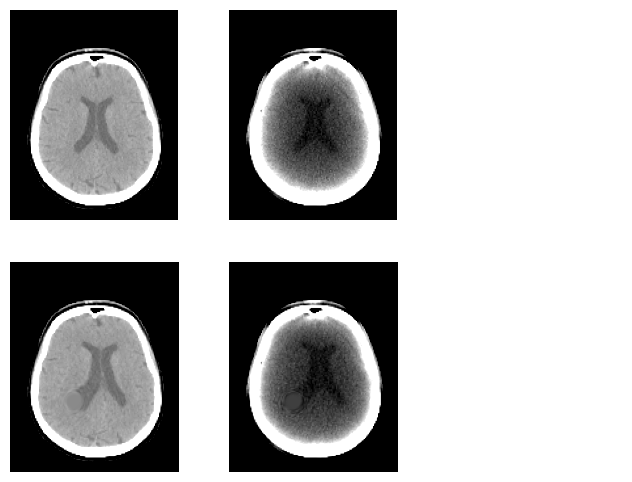

In [22]:
islice = 70
fig, ax = plt.subplots(2,3,figsize=(8,6))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0, 0].imshow(ct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 0].set_xlabel('Non-deformed CT')
ax[1, 0].imshow(ct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 0].set_xlabel('Deformed CT without scaling')
ax[0, 1].imshow(cbct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 1].set_xlabel('Non-deformed CBCT')
ax[1, 1].imshow(cbct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 1].set_xlabel('Deformed CBCT without scaling')
ax[0, 2].imshow(mr[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 2].set_xlabel('Non-deformed MRI')
ax[1, 2].imshow(mr_deform[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[1, 2].set_xlabel('Deformed MR without scaling')
plt.tight_layout()
plt.show()

NameError: name 'mr_deform_s' is not defined

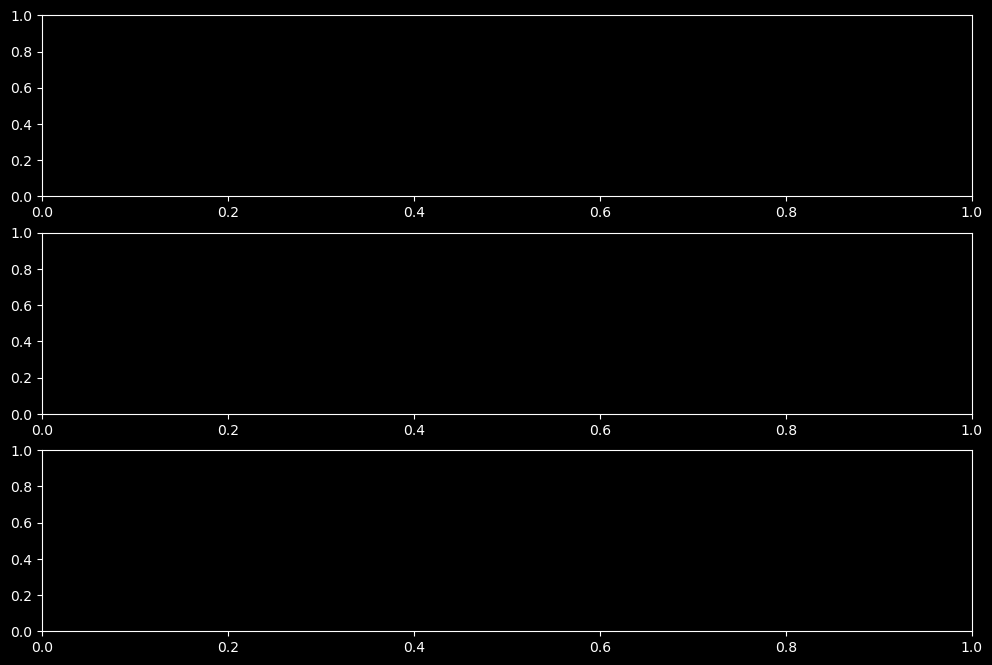

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')
fig, ax = plt.subplots(3,1,figsize=(12,8))
imx2 = ax[0].imshow(abs(mr_deform[:,:,islice].T-mr_deform_s[0,0,:,:,islice].T.numpy()), cmap='hot', vmin=0,vmax = 0.065)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imx2, cax=cax, orientation='vertical')
ax[0].set_title('Difference of scaled deformation')


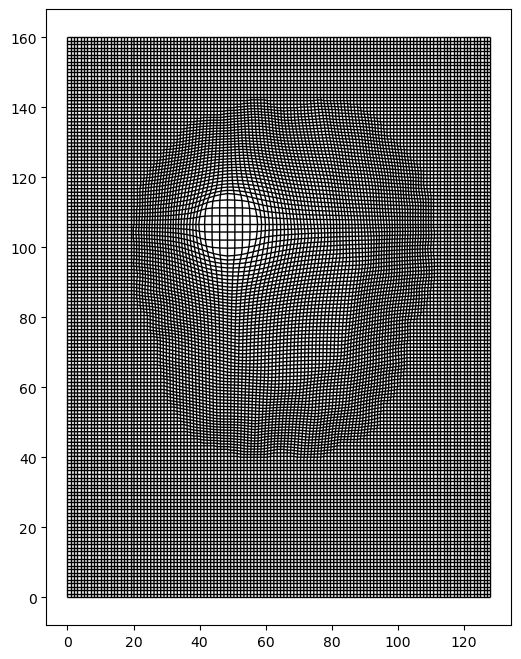

In [74]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6,8))
plot_flow(flow_unit[0].numpy().transpose(1,2,3,0), spacing=1, z=islice, ax=ax)

In [ ]:
flow_runze.shape

torch.Size([1, 3, 271, 340, 183])

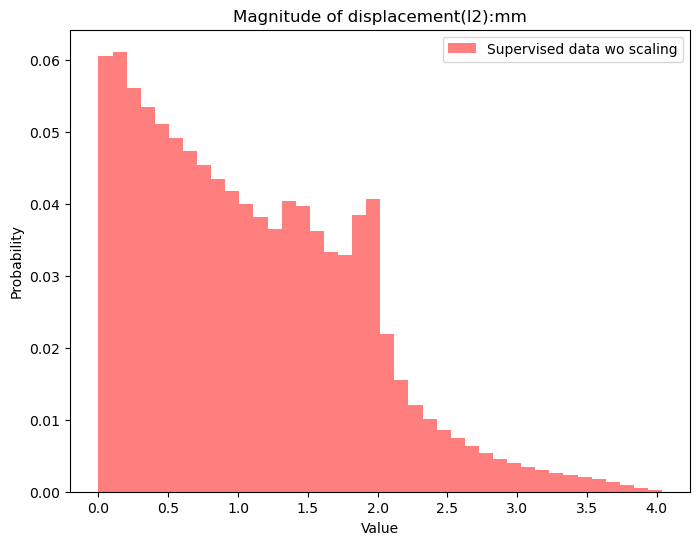

In [87]:
data = flow_runze
data[0,0,:,:,:]*= 0.7
data[0,1,:,:,:]*= 0.7
magnitude = ((data[0,0,:,:,:,])**2+(0.7*data[0,1,:,:,:])**2+data[0,2,:,:,:]**2)**0.5
mag_list = magnitude.flatten().tolist()
mag_list = [x for x in mag_list if x!=0.0]
weights = np.ones_like(mag_list)/len(mag_list)

plt.figure(figsize=(8, 6))

# 绘制两组数据的直方图
plt.hist(mag_list, bins=40, alpha=0.5, color='red', label = 'Supervised data wo scaling',weights=weights)

# 添加标签和图例
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Magnitude of displacement(l2):mm')
plt.legend()

# 显示图形
plt.show()

In [ ]:
torch.where(magnitude == magnitude.max())

(tensor([102]), tensor([225]), tensor([106]))

In [ ]:
magnitude[102, 225, 100]

tensor(6.5991e-06)

In [ ]:
from tqdm import tqdm
for i in tqdm(range(400)):
    data_dict = torch.load(os.path.join(write_dir, f"{i:03}.pt"))
    
    fixed_img = data_dict['ct_fixed']
    moving_img = data_dict['mr_moving']
    fixed_warp = data_dict['ct_moving']
    moving_truth = data_dict['moving_truth']
    ventricle_fixed = data_dict['seg_fixed']
    ventricle_moving = data_dict['seg_moving']
    affine = data_dict['affine']
    flow = data_dict['flow']
    cbct = data_dict['cbct_fixed']
    cbct_warp = data_dict['cbct_warp']

    output_dict = {}
    output_dict['fixed_img'] = fixed_img[0,0,:,:,:]
    output_dict['moving_img'] = moving_img.squeeze(0).squeeze(0).numpy()
    output_dict['fixed_warp'] = fixed_warp[0,0,:,:,:]
    output_dict['moving_truth'] = moving_truth.squeeze(0).squeeze(0).numpy()
    output_dict['ventricle_fixed'] = ventricle_fixed.squeeze(0).squeeze(0).numpy()
    output_dict['ventricle_moving'] = ventricle_moving.squeeze(0).squeeze(0).numpy()
    output_dict['affine'] = affine 
    output_dict['flow'] = flow.squeeze(0).numpy()
    output_dict['cbct'] = cbct.squeeze(0).squeeze(0).numpy()
    output_dict['cbct_warp'] = cbct_warp.squeeze(0).squeeze(0).numpy()

    np.savez(os.path.join(write_dir, f"{i:03}.npz"),
             fixed_img=fixed_img[0,0,:,:,:], moving_img=moving_img.squeeze(0).squeeze(0).numpy(), fixed_warp= fixed_warp[0,0,:,:,:],
             moving_truth=moving_truth.squeeze(0).squeeze(0).numpy(), ventricle_fixed=ventricle_fixed.squeeze(0).squeeze(0).numpy(), ventricle_moving=ventricle_moving.squeeze(0).squeeze(0).numpy(),
             affine=affine, flow=flow.squeeze(0).numpy(), sources=None,
             cbct=cbct.squeeze(0).squeeze(0).numpy(), cbct_warp=cbct_warp.squeeze(0).squeeze(0).numpy(), index=i)

    

In [ ]:
import os

# 指定要删除文件的目录路径
directory = "/home/myi16/jsr_Y/new_data"
# 获取目录中的所有文件名
file_list = os.listdir(directory)

# 遍历文件列表并删除每个文件
for filename in file_list:
    if filename.endswith('.pt'):
        file_path = os.path.join(directory, filename)
        try:
            # 删除文件
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")